In [114]:
import xgboost as xgb
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import matthews_corrcoef

In [9]:
hyperparams = {'learning_rate': 0.22205346352424176, 'max_delta_step': 2.1132866218907003, 'max_depth': 8, 'min_child_weight': 1.9215635292274276, 'num_rounds': 779.304784864205, 'reg_alpha': 0.6126926526952088, 'reg_lambda': 3.238607289889072, 'weight': 0.24922052982680407}

hyperparams['objective'] = 'binary:logistic'
hyperparams['eval_metric'] = 'error'
hyperparams['tree_method'] = "gpu_hist"
hyperparams['sampling_method'] = 'gradient_based'

In [10]:
df_train = pd.read_pickle("training_data.pkl")
df_test = pd.read_pickle("test_data.pkl")

In [11]:
num_rounds = hyperparams["num_rounds"]
weights = np.array([hyperparams["weight"] if binding == 0 else 1.0 for binding in df_train["outcome"]])
hyperparams["max_depth"] = int(hyperparams["max_depth"])
del hyperparams["num_rounds"]
del hyperparams["weight"]

In [12]:
feature_names =  ["ECFP_" + str(i) for i in range(1024)]
feature_names = feature_names + ["ESM1b_" + str(i) for i in range(1280)]

In [13]:
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b"][ind]
        ecfp = np.array(list(df["ECFP"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), )
        y = y + (df["outcome"][ind], )

    return(np.array(X), np.array(y))

In [14]:

train_X, train_y =  create_input_and_output_data(df = df_train)

dtrain = xgb.DMatrix(
    np.array(train_X), 
    weight = weights, 
    label = np.array(train_y),
    feature_names= feature_names
)

model = xgb.train(
    hyperparams, 
    dtrain, 
    int(num_rounds)
)

In [15]:
test_X, test_y =  create_input_and_output_data(df = df_test)

dtest = xgb.DMatrix(
    np.array(test_X), 
    label = np.array(test_y),
    feature_names= feature_names
)

y_test_pred = model.predict(dtest)

In [16]:
acc_test = np.mean(np.round(y_test_pred) == np.array(test_y))
roc_auc = roc_auc_score(np.array(test_y), y_test_pred)
mcc = matthews_corrcoef(np.array(test_y), np.round(y_test_pred))

print(f"Genauigkeit: ~{np.round(acc_test, 4)}")
print(f"ROC-AUC: ~{np.round(roc_auc, 4)}")
print(f"MCC: ~{np.round(mcc, 4)}")

Genauigkeit: ~0.8475
ROC-AUC: ~0.8742
MCC: ~0.5987


In [17]:
df_test["prediction"] = np.round(y_test_pred)
seq_identity = ["60-80%", "40-60%", "<40%"]

for identity in seq_identity:
    y_true = np.array(df_test["outcome"].loc[df_test["Sequence identity"] == identity])
    y_pred = np.array(df_test["prediction"].loc[df_test["Sequence identity"] == identity])
    acc = np.mean(y_pred == np.array(y_true))
    mcc = matthews_corrcoef(np.array(y_true), y_pred)
    print(f"Ähnlichkeit: {identity}, Genauigkeit: {np.round(acc, 4)}, MCC: {np.round(mcc, 4)}\n")

Ähnlichkeit: 60-80%, Genauigkeit: 0.868, MCC: 0.6692

Ähnlichkeit: 40-60%, Genauigkeit: 0.8452, MCC: 0.6053

Ähnlichkeit: <40%, Genauigkeit: 0.8378, MCC: 0.5577



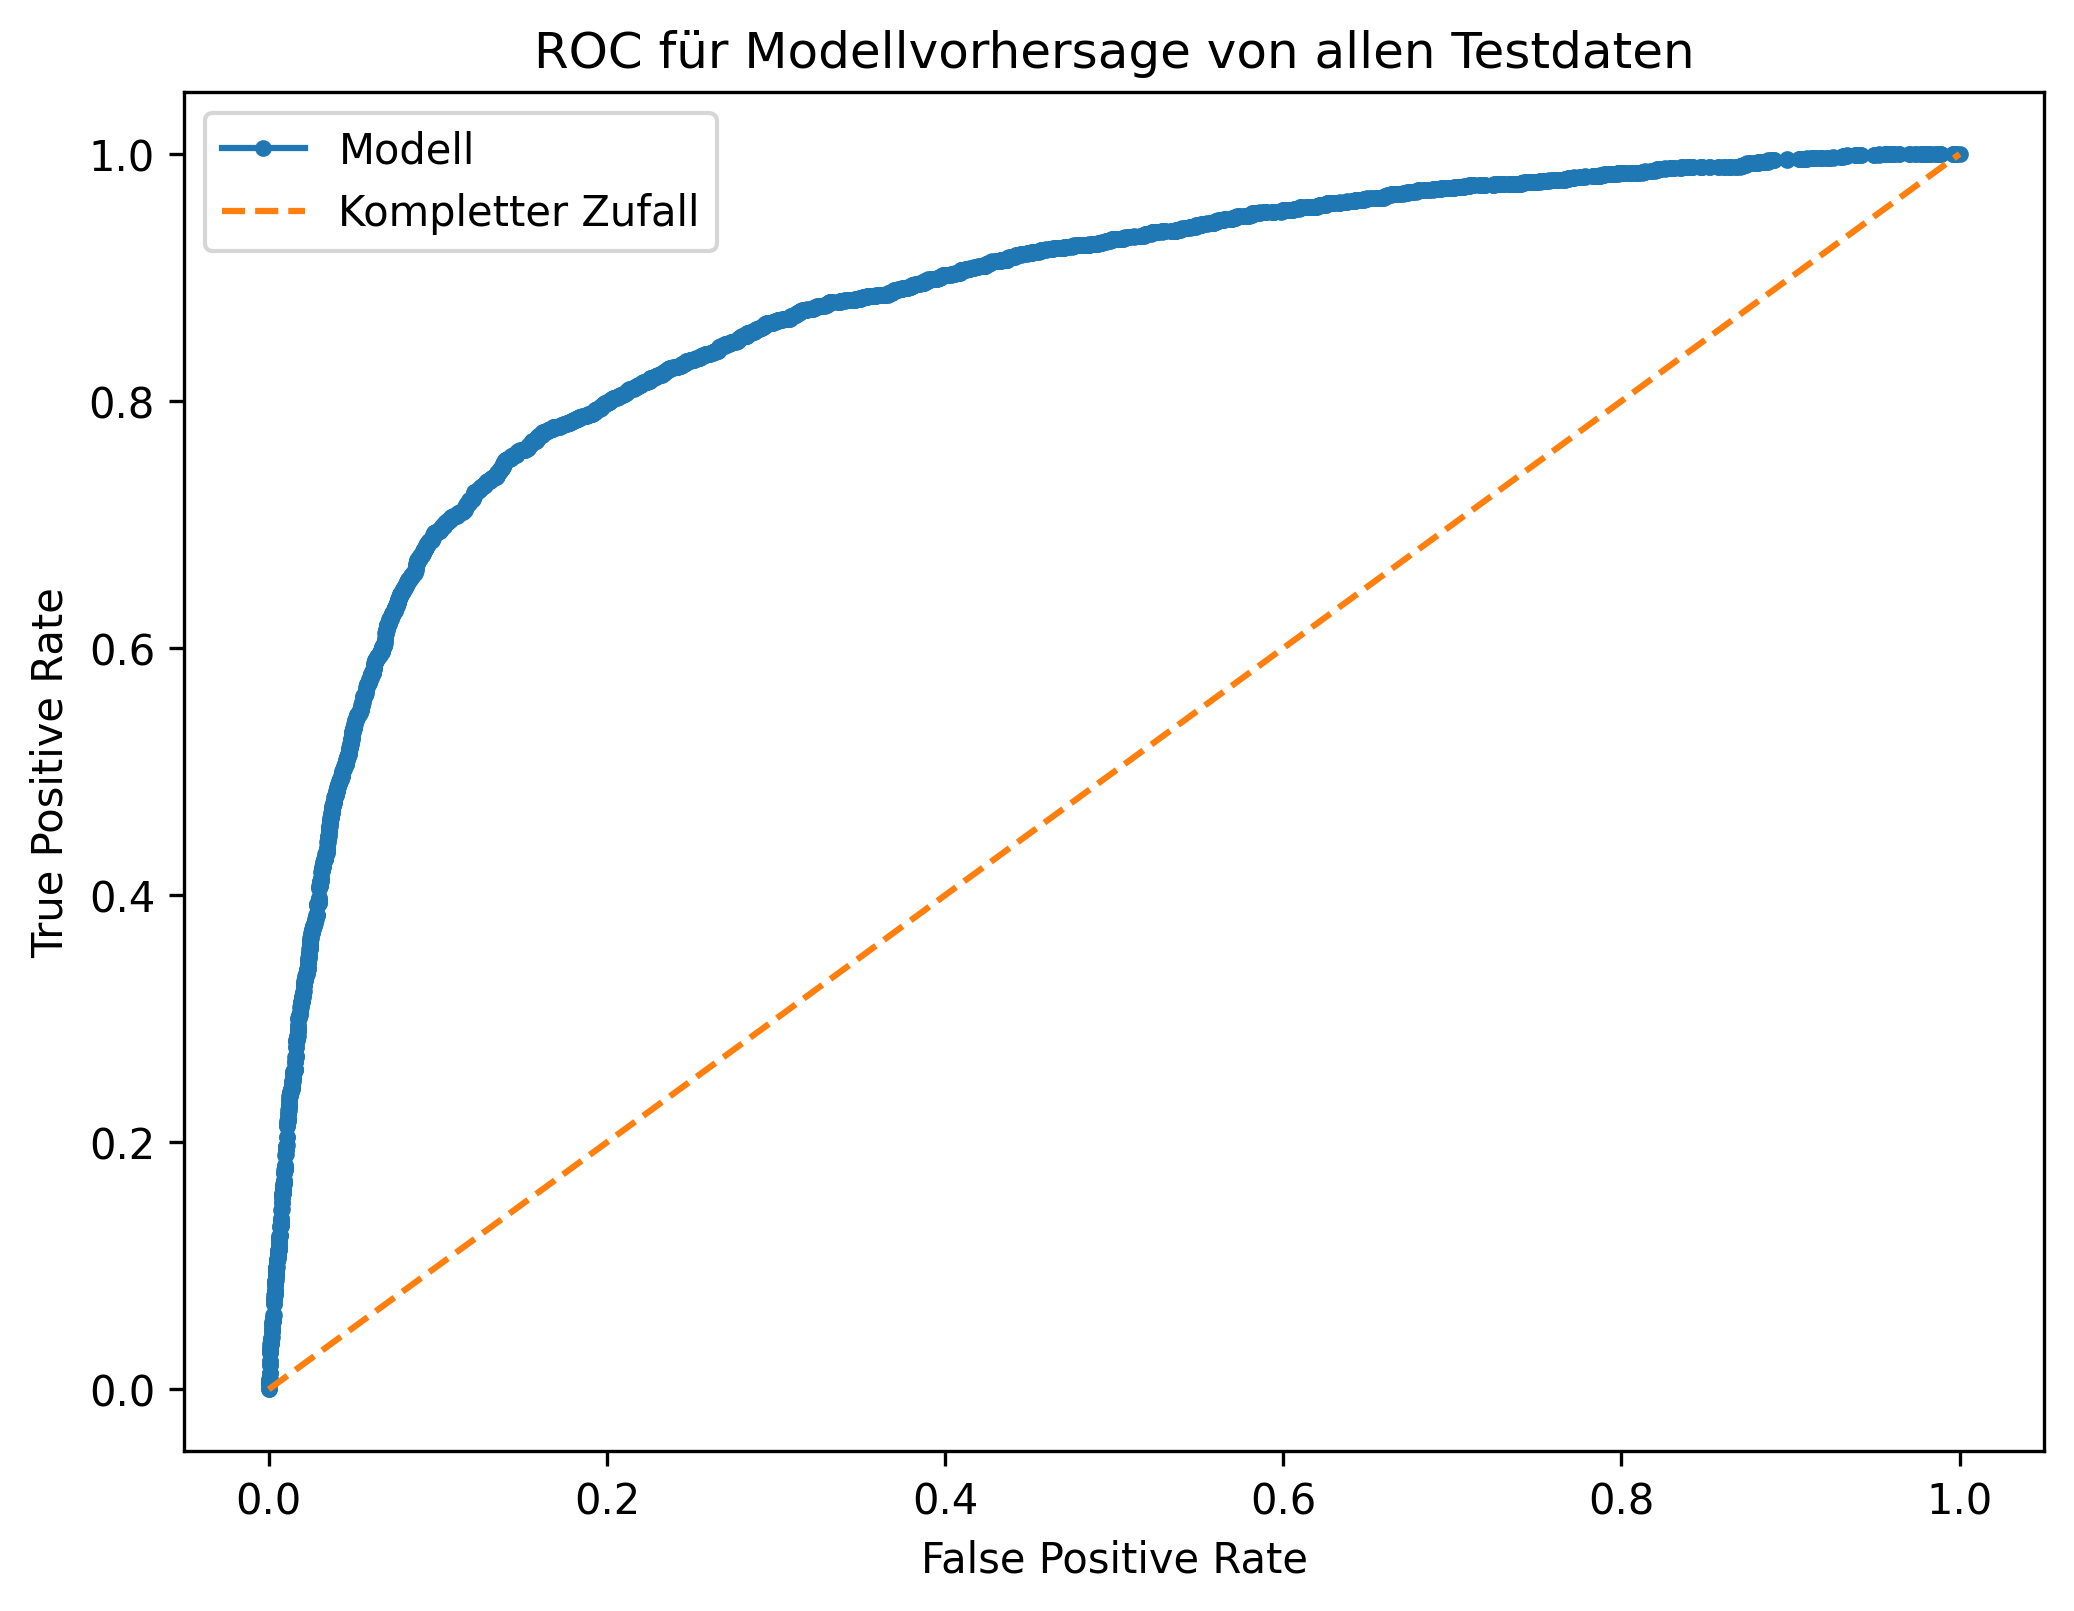

In [26]:
fpr, tpr, _ = roc_curve(test_y, y_test_pred)

z = [0 for _ in range(len(test_y))]
fpr_z, tpr_z, _ = roc_curve(test_y, z)

figure = plt.figure(figsize = (8,6),dpi = 300)
plt.plot(fpr, tpr, marker='.', label = "Modell")
plt.plot(fpr_z, tpr_z, linestyle='--', label = "Kompletter Zufall")
plt.title("ROC für Modellvorhersage von allen Testdaten")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Ähnlichkeit: 60-80%, AUC: 0.9103
Ähnlichkeit: 40-60%, AUC: 0.8783
Ähnlichkeit: <40%, AUC: 0.8497


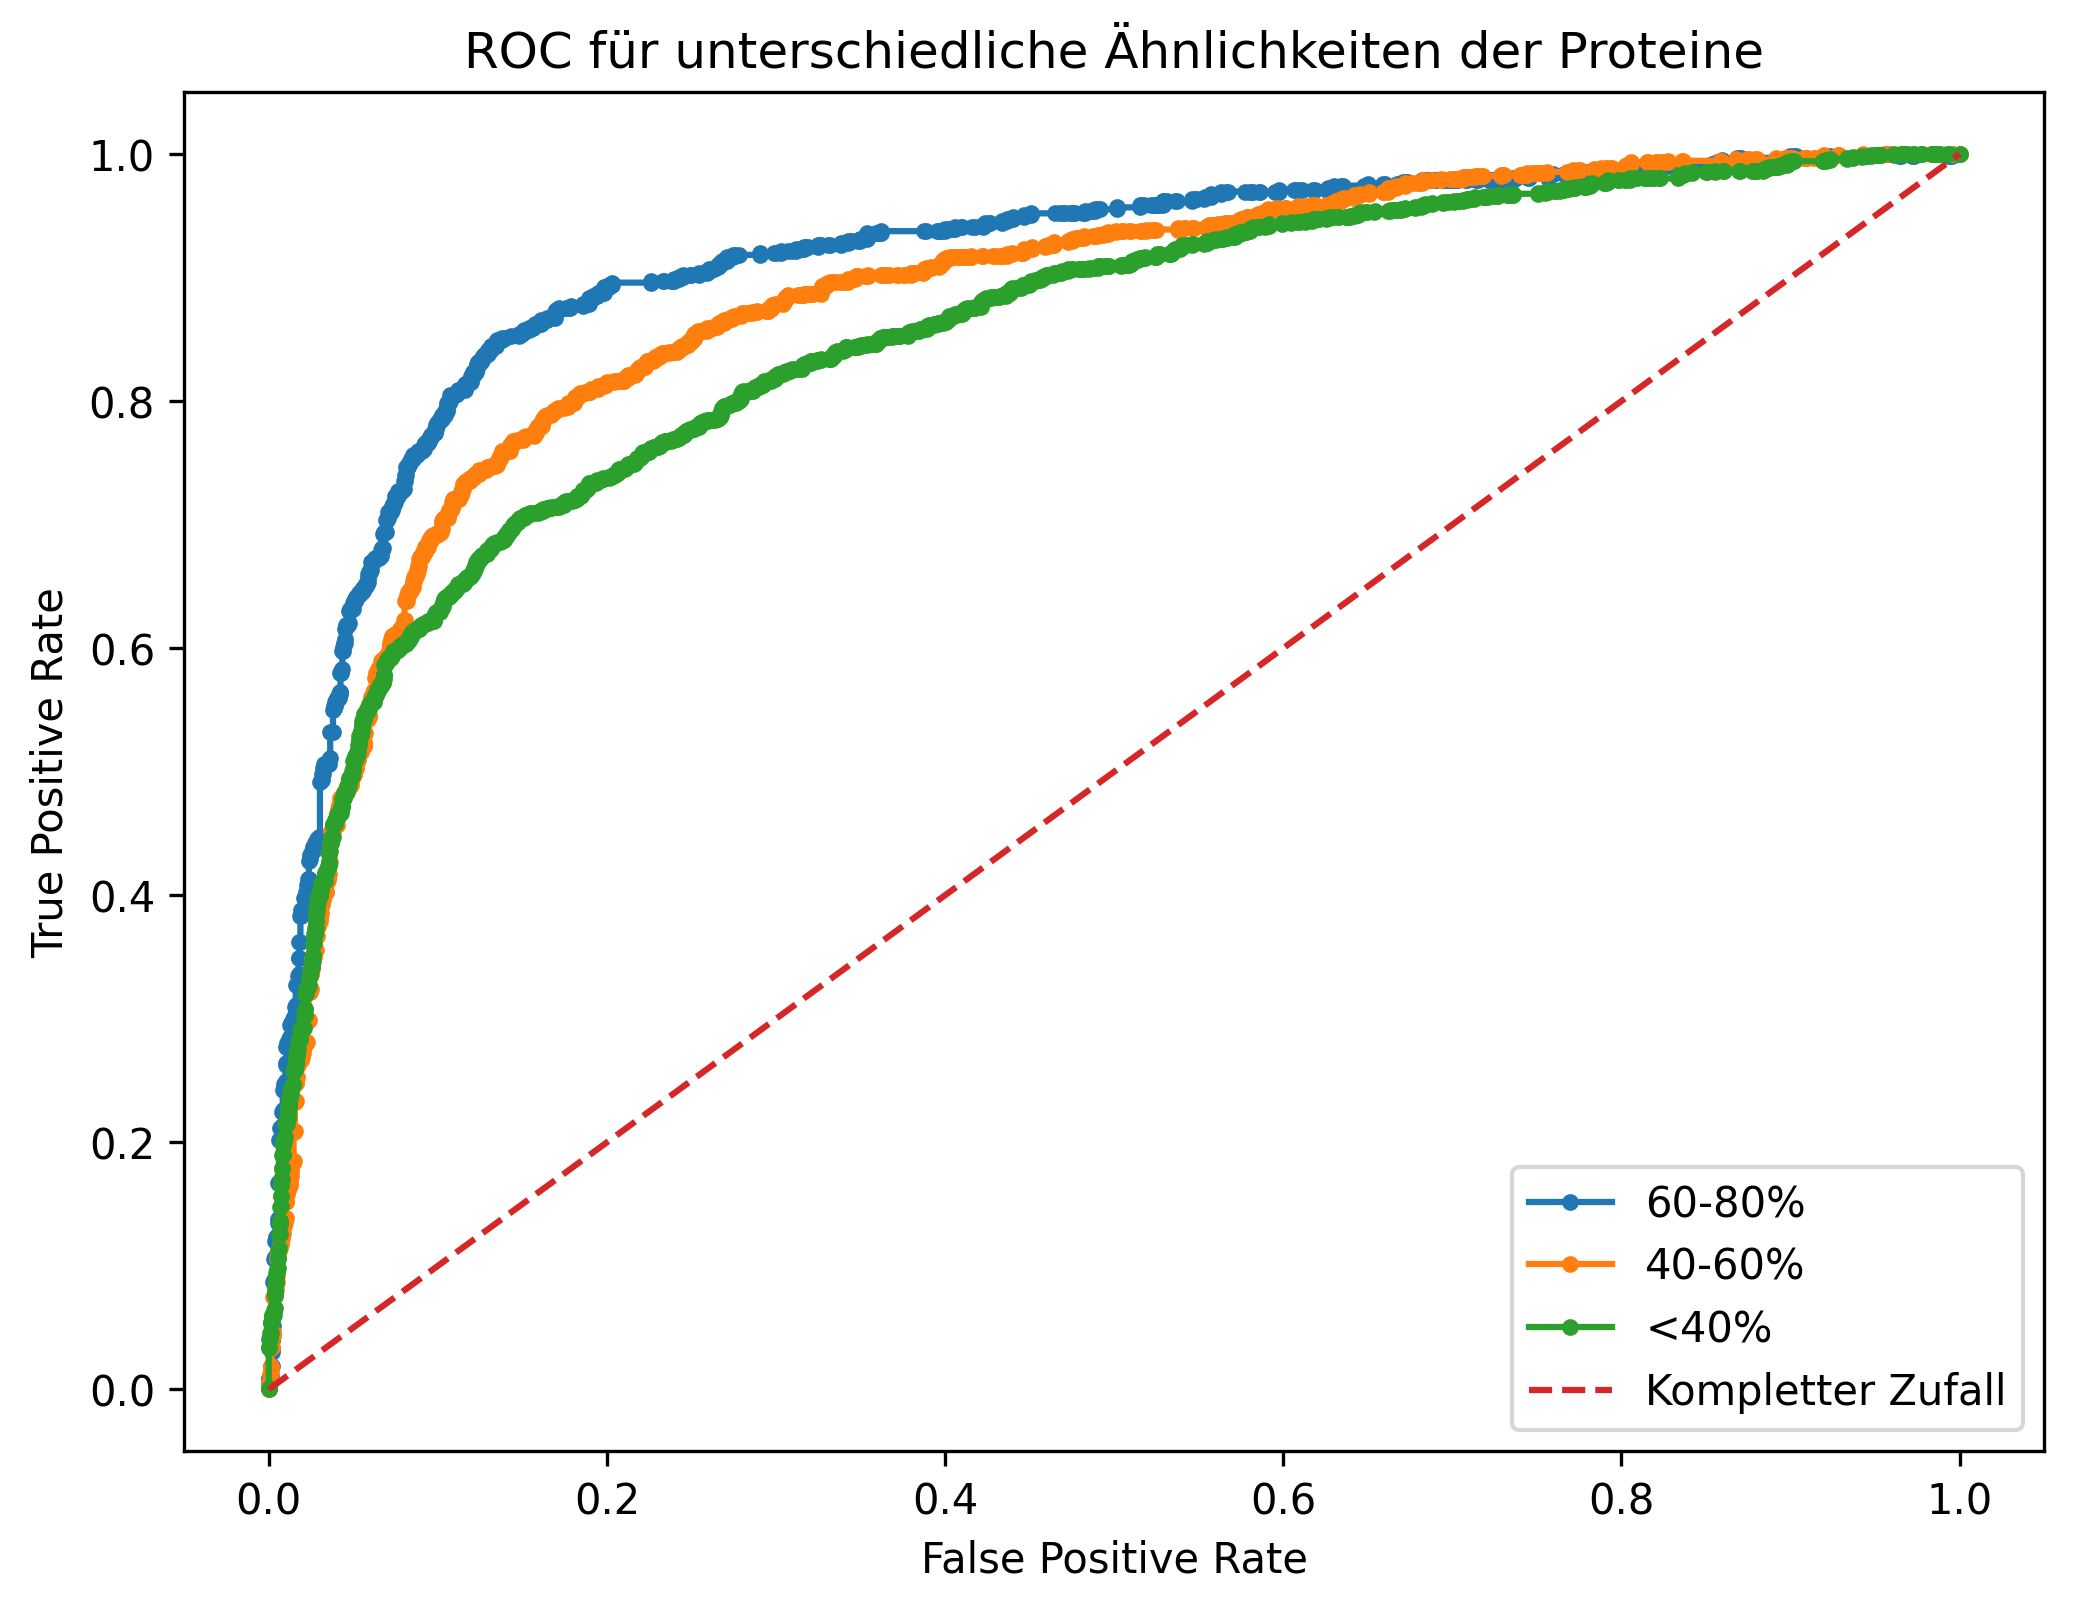

In [27]:
df_test["prediction"] = y_test_pred
seq_identity = ["60-80%", "40-60%", "<40%"]

figure = plt.figure(figsize = (8,6),dpi = 300)

for identity in seq_identity:
    y_true = np.array(df_test["outcome"].loc[df_test["Sequence identity"] == identity])
    y_pred = np.array(df_test["prediction"].loc[df_test["Sequence identity"] == identity])
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, marker='.', label = identity)
    roc_auc = roc_auc_score(np.array(y_true), y_pred)
    print(f"Ähnlichkeit: {identity}, AUC: {np.round(roc_auc, 4)}")

z = [0 for _ in range(len(test_y))]
fpr_z, tpr_z, _ = roc_curve(test_y, z)
plt.plot(fpr_z, tpr_z, linestyle='--', label = "Kompletter Zufall")
plt.title("ROC für unterschiedliche Ähnlichkeiten der Proteine")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

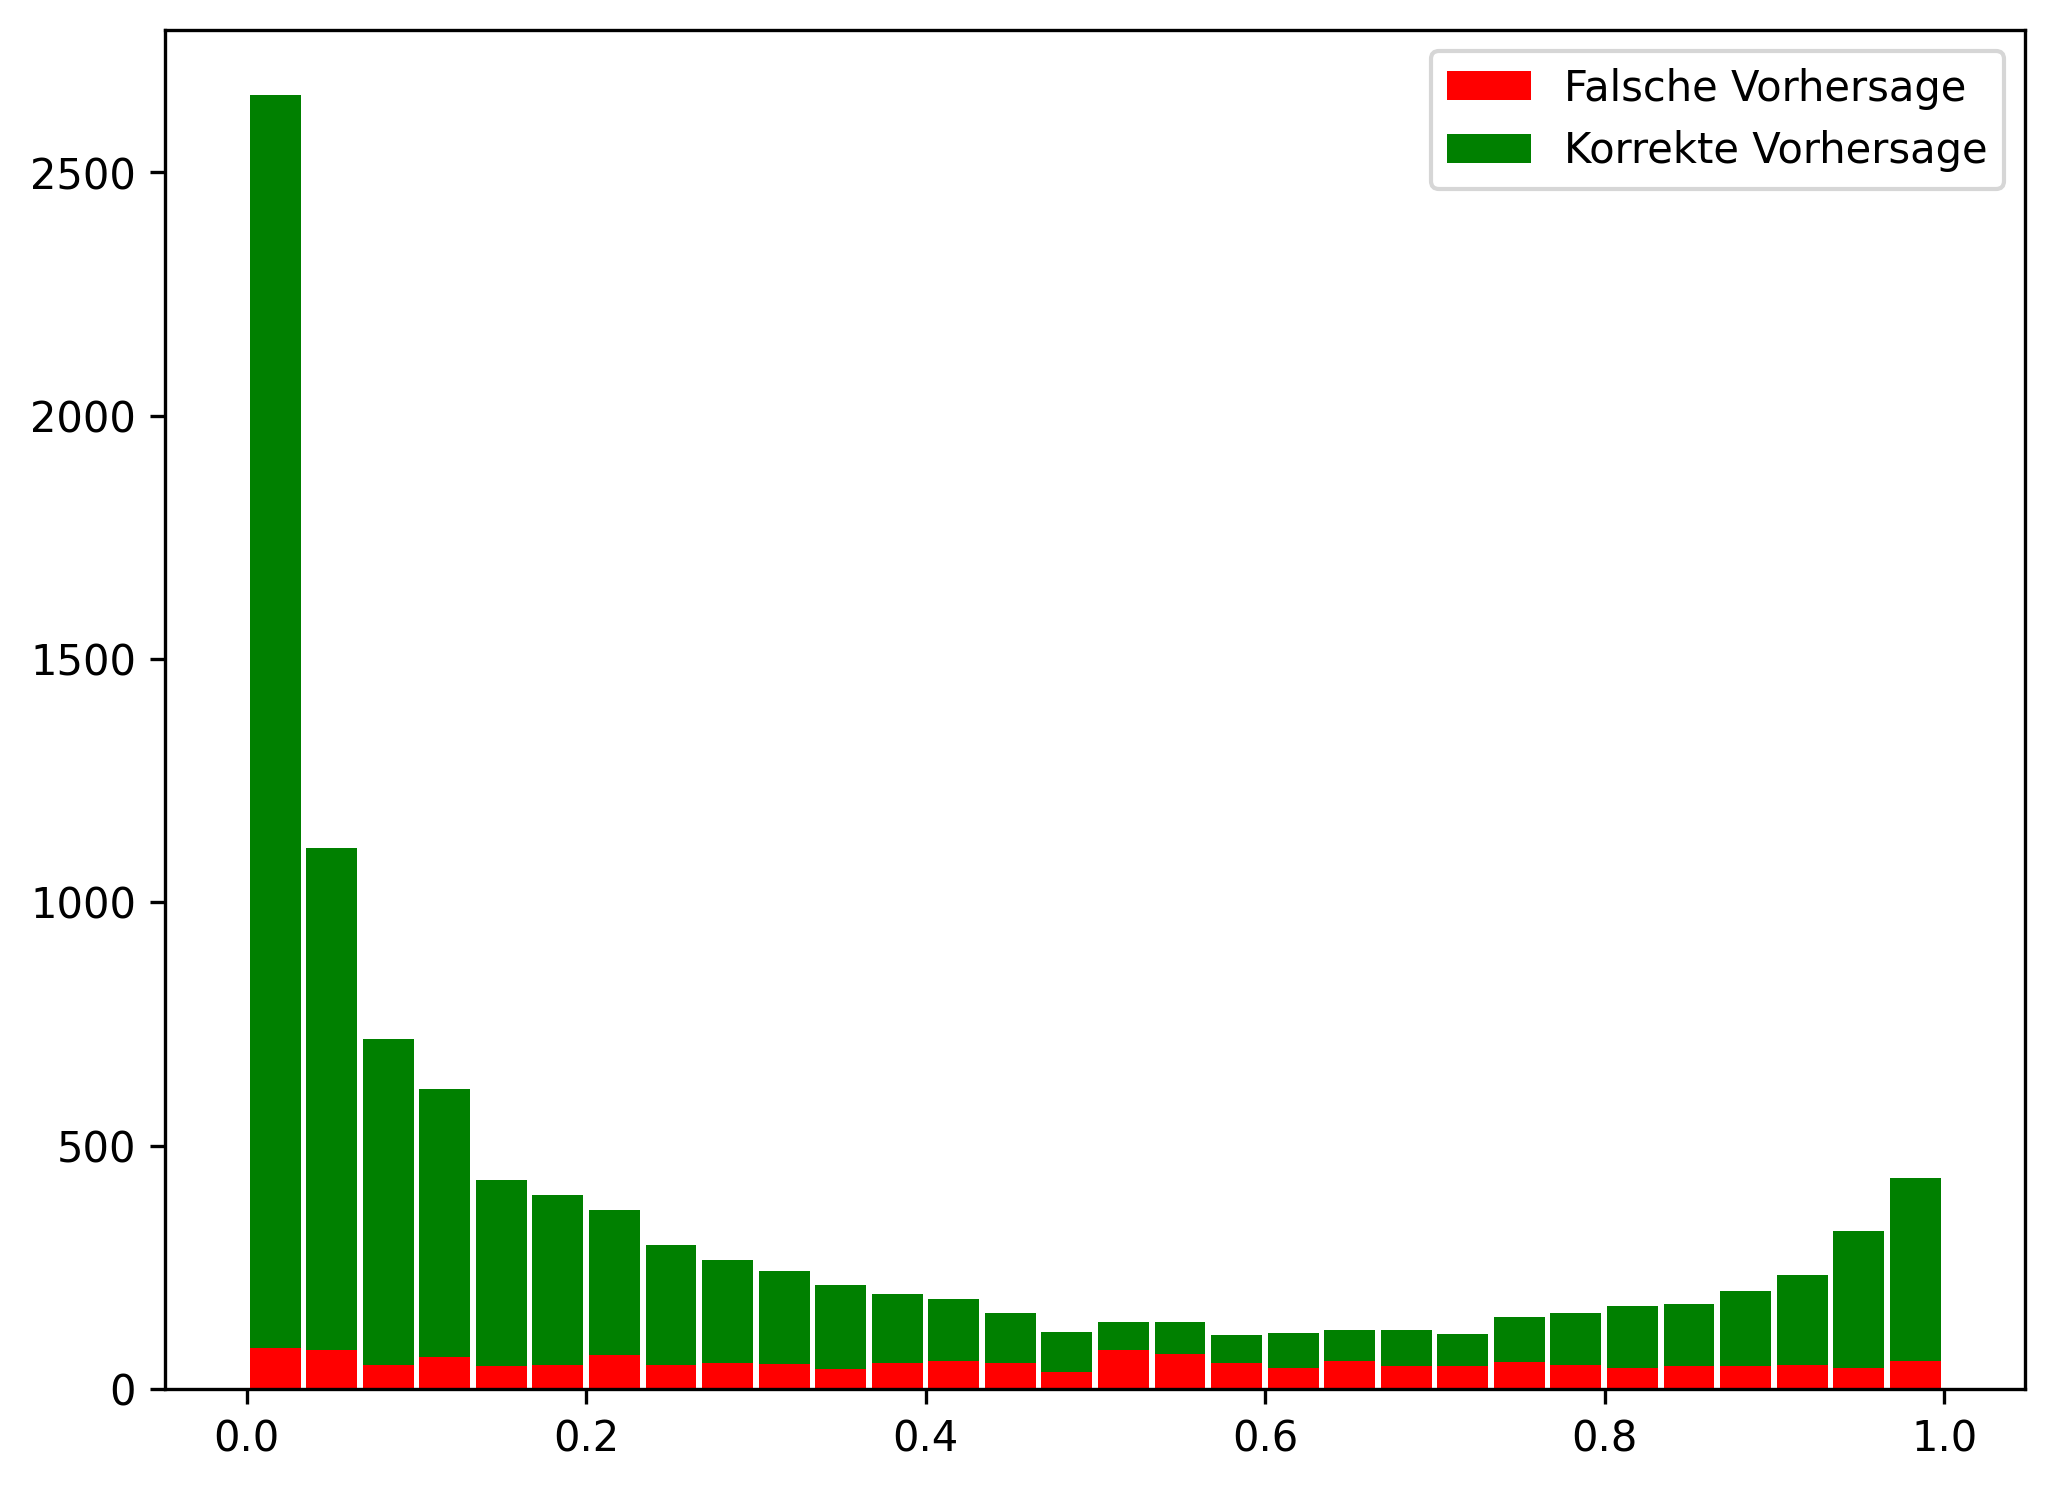

In [28]:
x = [
    y_test_pred[np.round(y_test_pred) != test_y],
    y_test_pred[np.round(y_test_pred) == test_y]
]

plt.figure(figsize = (8,6),dpi = 300)
plt.hist(
    x, 
    bins = 30,
    rwidth = 0.9,
    stacked = True,
    color = ["red", "green"],
    label = ["Falsche Vorhersage", "Korrekte Vorhersage"]
)
plt.legend()
plt.show()

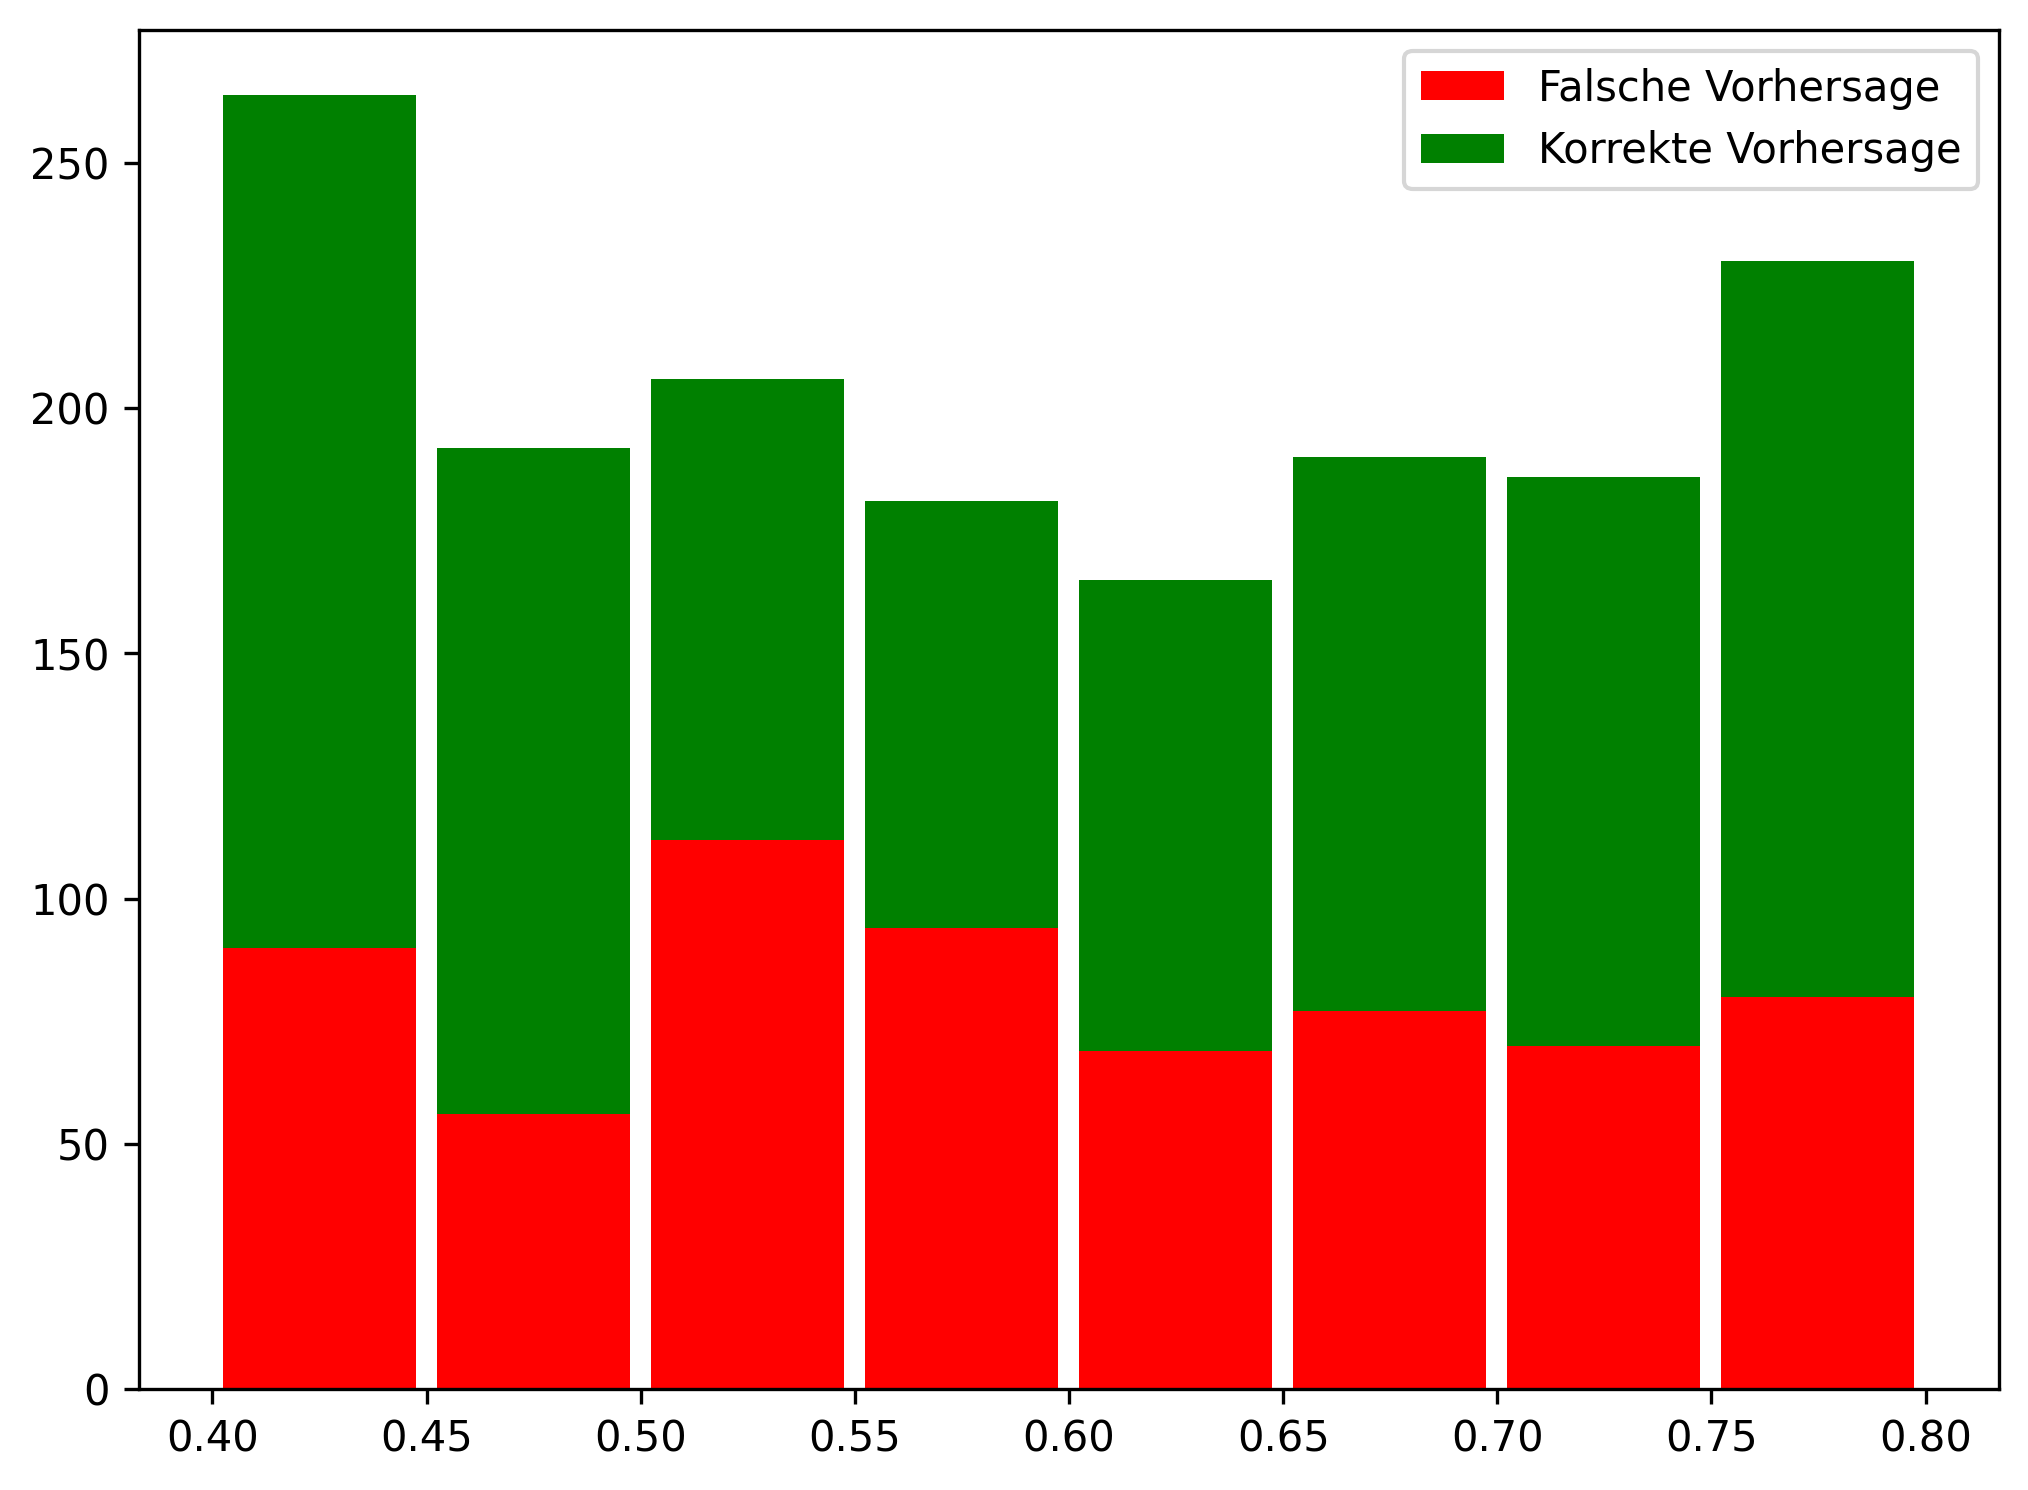

In [29]:
b = np.logical_and(y_test_pred >= 0.4, y_test_pred <= 0.8)
p = y_test_pred[b]
t = test_y[b]
x = [
    p[np.round(p) != t],
    p[np.round(p) == t]
]

plt.figure(figsize = (8,6),dpi = 300)
plt.hist(
    x, 
    bins = 8, 
    stacked = True,
    rwidth = 0.9,
    color = ["red", "green"],
    label = ["Falsche Vorhersage", "Korrekte Vorhersage"]
)
plt.legend()
plt.show()

In [35]:
print(f"Anteil gesamter Testdaten: {np.round(len(p) / len(b), 4)}")
print(f"Genauigkeit: {len(p[np.round(p) == t]) / len(p)}")

Anteil gesamter Testdaten: 0.1514
Genauigkeit: 0.5985130111524164


In [53]:
m_train = df_train["molecule ID"].drop_duplicates()
m_test = df_test["molecule ID"].drop_duplicates()

print(f"""Anzahl Substrate (ohne Duplikate):
- Trainingsdatensatz (insgesamt): {m_train.size}
- Testdatensatz (insgesamt): {m_test.size}
- Substrate, die in Testdaten vorkommen, aber nicht in den Trainingsdaten: {m_test[~m_test.isin(m_train)].size}""")

Anzahl Substrate (ohne Duplikate):
- Trainingsdatensatz (insgesamt): 1208
- Testdatensatz (insgesamt): 695
- Substrate, die in Testdaten vorkommen, aber nicht in den Trainingsdaten: 89


Anzahl Substrate für <40% insgesamt: 		4662
Anzahl Substrate in Training von Test: 		4451
Anzahl Substrate nicht in Training von Test: 	211
Genauigkeit: 0.782, MCC: -0.1012, AUC: 0.6571

Anzahl Substrate für 40-60% insgesamt: 		3489
Anzahl Substrate in Training von Test: 		3326
Anzahl Substrate nicht in Training von Test: 	163
Genauigkeit: 0.8589, MCC: 0.1393, AUC: 0.5483

Anzahl Substrate für 60-80% insgesamt: 		2440
Anzahl Substrate in Training von Test: 		2336
Anzahl Substrate nicht in Training von Test: 	104
Genauigkeit: 0.8173, MCC: 0.3994, AUC: 0.8052



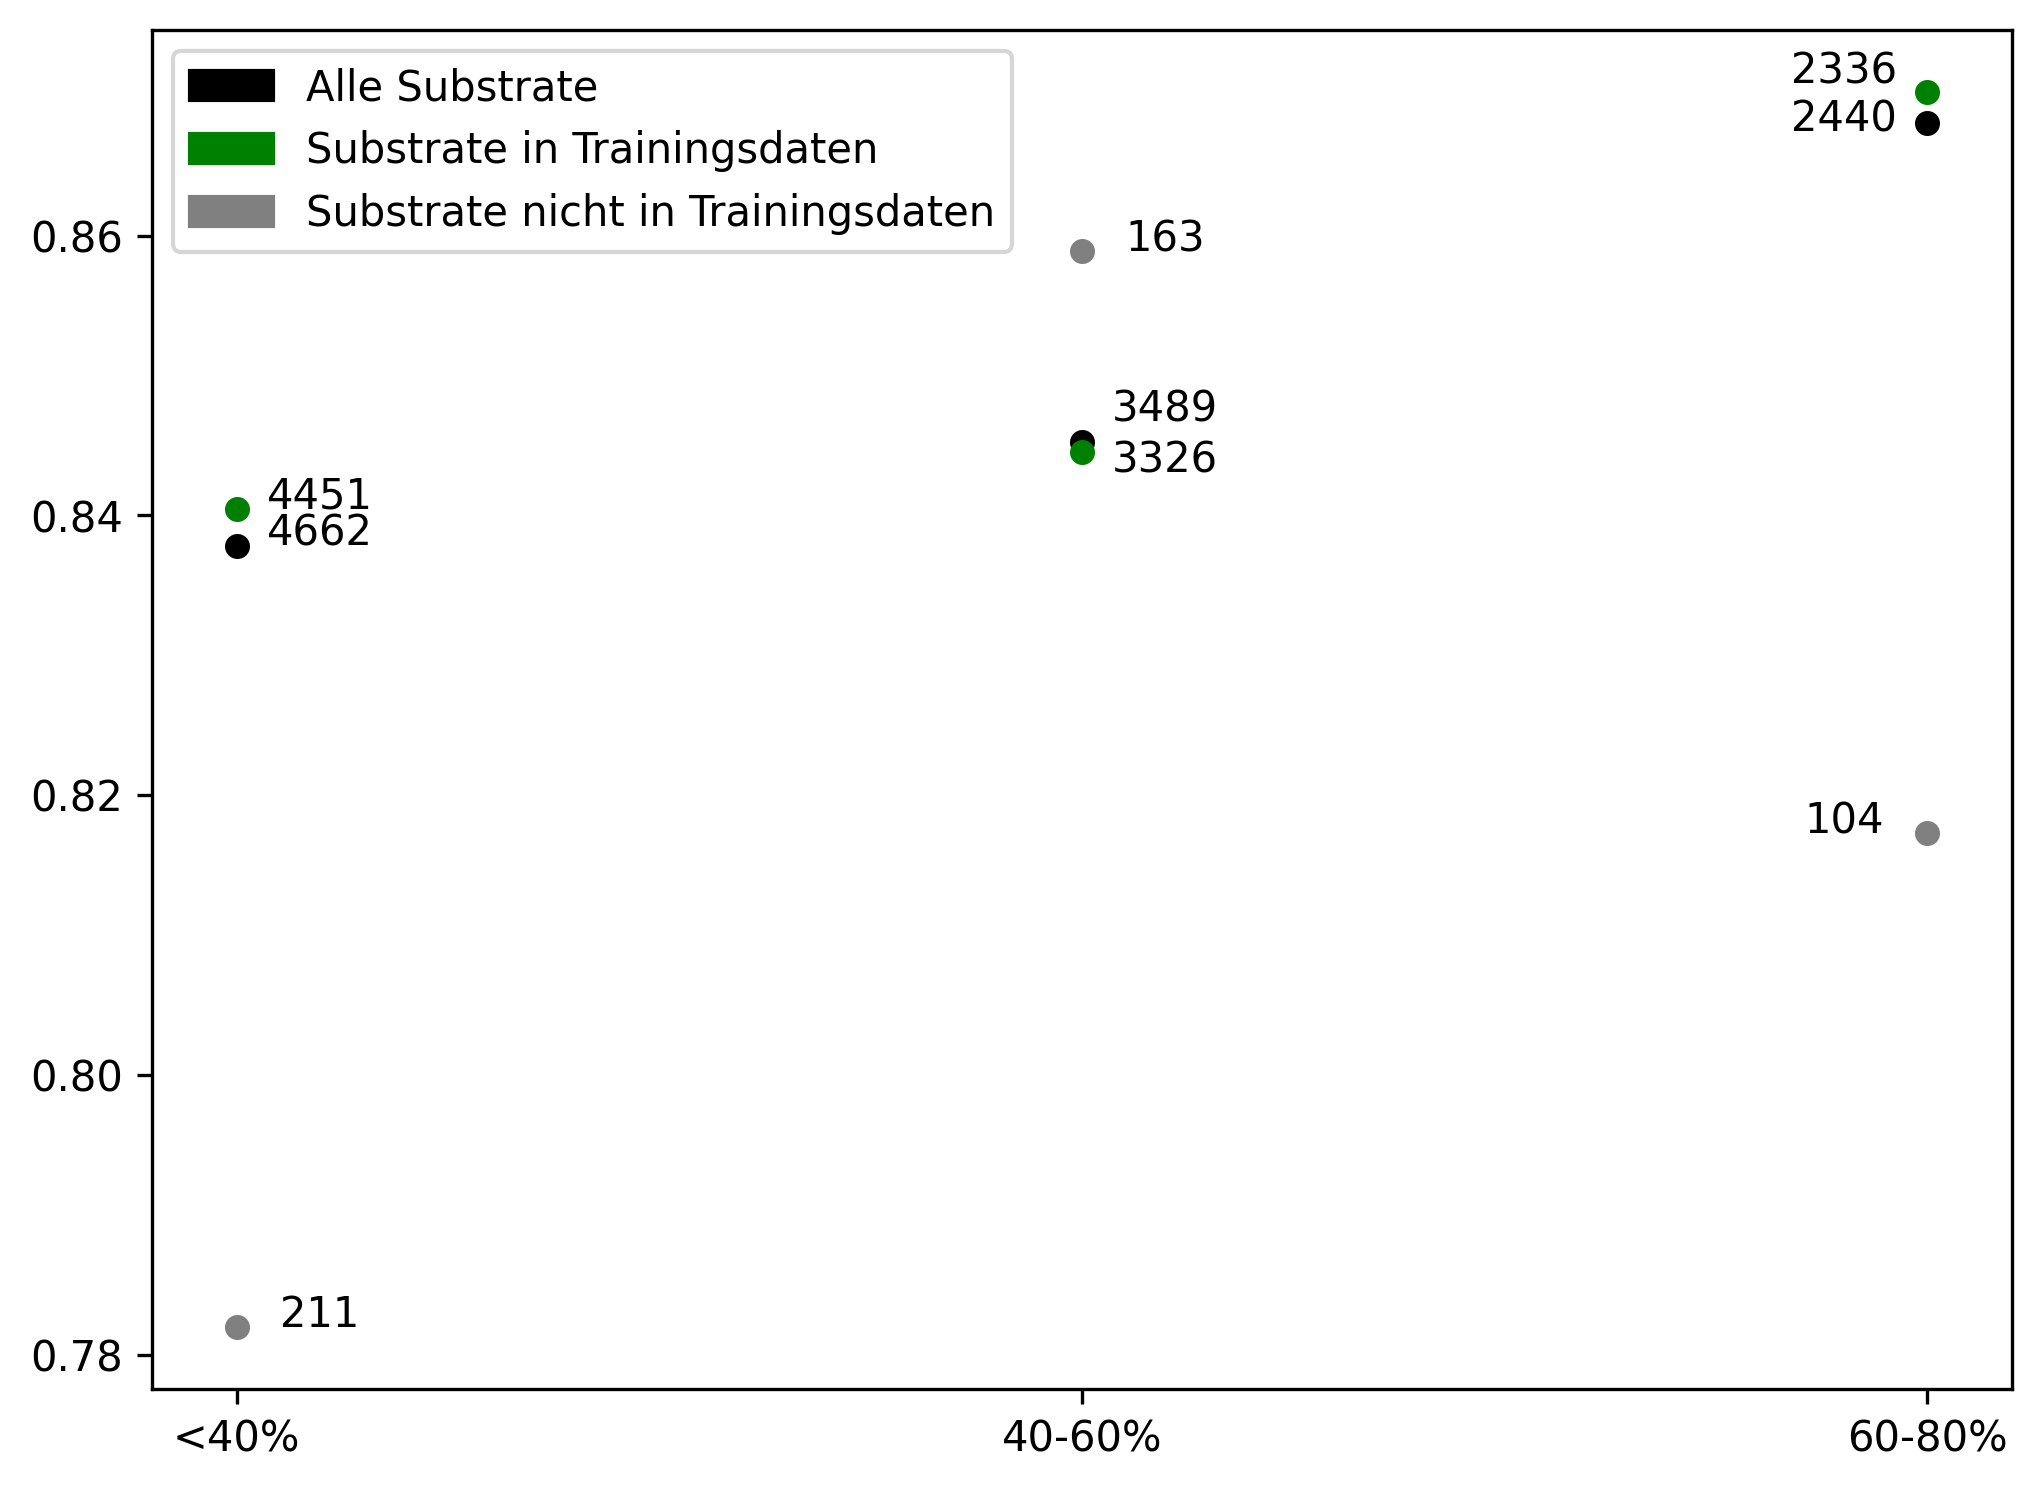

In [118]:
df_test["prediction"] = y_test_pred
seq_identity = ["<40%", "40-60%", "60-80%"]
plt.figure(figsize = (8,6),dpi = 300)

r = 0

for identity in seq_identity:
    test = df_test.loc[df_test["Sequence identity"] == identity]
    
    all = test['molecule ID'].size
    is_in = test[test['molecule ID'].isin(m_train)]['molecule ID'].size
    not_in = all - is_in

    x = test[test['molecule ID'].isin(m_train)]
    y = test[~test['molecule ID'].isin(m_train)]

    print(f"Anzahl Substrate für {identity} insgesamt: \t\t{all}")
    print(f"Anzahl Substrate in Training von Test: \t\t{is_in}")
    print(f"Anzahl Substrate nicht in Training von Test: \t{not_in}")
    
    acc = np.mean(np.round(y["prediction"]) == y["outcome"])
    mcc = matthews_corrcoef(y["outcome"], np.round(y["prediction"]))
    roc_auc = roc_auc_score(y["outcome"], y["prediction"])

    print(f"Genauigkeit: {np.round(acc, 4)}, MCC: {np.round(mcc, 4)}, AUC: {np.round(roc_auc, 4)}\n")
    
    plt.plot(identity, np.mean(test["outcome"] == np.round(test["prediction"])), "o", markersize=5, color="black")
    plt.plot(identity, np.mean(x["outcome"] == np.round(x["prediction"])), "o", markersize=5, color="green")
    plt.plot(identity, np.mean(y["outcome"] == np.round(y["prediction"])), "o", markersize=5, color="grey")
    
    x_coord = 20
    offset = 0
    if r == 0:
        r += 1
    elif r == 1:
        offset = 5
        r += 1
    else:
        x_coord = -20
        offset = -2
    
    plt.annotate(all, (identity, np.mean(test["outcome"] == np.round(test["prediction"]))), ha='center', textcoords="offset points", xytext=(x_coord,offset))
    plt.annotate(is_in, (identity, np.mean(x["outcome"] == np.round(x["prediction"]))), ha='center', textcoords="offset points", xytext=(x_coord,-offset))
    plt.annotate(not_in, (identity, np.mean(y["outcome"] == np.round(y["prediction"]))), ha='center', textcoords="offset points", xytext=(x_coord, 0))

plt.legend(handles = [
    mpatches.Patch(color='black', label='Alle Substrate'),
    mpatches.Patch(color='green', label='Substrate in Trainingsdaten'),
    mpatches.Patch(color='grey', label='Substrate nicht in Trainingsdaten')
])
plt.show()

In [106]:
(1, 2)[0]

1